# Deep Q-Network (DQN) Training Notebook

This notebook trains a **DQN with CNN** agent on the Snake game.

**Grid Size:** 10×10 (optimal for DQN)

**Expected Performance:**

- Episodes to convergence: 2000-3000
- Final average score: 15-25 apples
- Training time: 15-20 minutes (CPU) / 5-10 minutes (GPU)

---


## 1. Setup and Imports


In [ ]:
# For Google Colab
# !git clone https://github.com/MarinCervinschi/rl-snake.git
# %cd rl-snake

In [35]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

import random
from typing import List, Deque
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

from game.config import GameConfig
from game.engine import SnakeGameEngine
from game.entities import Action, State
from utils.metrics import TrainingMetrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Using device: {device}")

🖥️  Using device: cpu


## 2. DQN Components


In [36]:
class ConvQNetwork(nn.Module):
    """
    Convolutional Q-Network for processing grid states.

    Input: (4, H, W) -> 4 channels (Head, Body, Food, Time)
    Output: Q-values for each action
    """

    def __init__(self, grid_size: int, num_actions: int = 4):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.flat_size = 64 * grid_size * grid_size

        self.fc = nn.Sequential(
            nn.Linear(self.flat_size, 256),
            nn.ReLU(),
            nn.Linear(256, num_actions),
        )

        self._init_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass."""
        features = self.conv(x)
        flat = features.view(features.size(0), -1)
        q_values = self.fc(flat)
        return q_values

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


class ReplayBuffer:
    def __init__(self, capacity: int = 100_000):
        self.buffer: Deque = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32),
        )

    def __len__(self):
        return len(self.buffer)

## 3. DQN Agent


In [37]:
class DQNAgent:

    def __init__(
        self,
        grid_size: int = 10,
        learning_rate: float = 0.0001,
        discount_factor: float = 0.99,
        epsilon: float = 1.0,
        min_epsilon: float = 0.05,
        number_episodes: int = 15_000,
        learning_starts: int = 15_000,
        batch_size: int = 64,
        buffer_size: int = 100_000,
        target_update_freq: int = 1_000,
        continue_training: bool = False,
    ):
        self.grid_size = grid_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = epsilon
        self.epsilon_start = epsilon
        self.epsilon_end = min_epsilon
        self.epsilon_decay_episodes = int(0.75 * number_episodes)
        self.learning_starts = learning_starts
        
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq

        # Networks
        self.q_network = ConvQNetwork(grid_size).to(device)
        self.target_network = ConvQNetwork(grid_size).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.AdamW(self.q_network.parameters(), lr=learning_rate)

        self.criterion = nn.SmoothL1Loss()

        self.memory = ReplayBuffer(buffer_size)

        # Training statistics
        self.steps = 0
        self.episodes_trained = 0
        self.losses: List[float] = []

        if continue_training:
            self.load()

    def get_action(self, state: State, training: bool = True) -> Action:
        """
        Select action with adaptive epsilon-greedy.

        Args:
            state: Current game state
            training: If False, uses greedy policy (no exploration)
        """
        # During warmup: pure exploration
        if training and self.steps < self.learning_starts:
            return random.choice(list(Action))

        # Epsilon-greedy (only during training)
        if training and random.random() < self.epsilon:
            return random.choice(list(Action))

        # Greedy action from Q-network
        state_tensor = self._state_to_tensor(state)
        with torch.no_grad():
            q_values = self.q_network(state_tensor)
        return Action(q_values.argmax().item())

    def train(
        self, state: State, action: Action, reward: float, next_state: State, done: bool
    ):
        """Single training step."""
        state_array = state.to_tensor()
        next_state_array = next_state.to_tensor()

        # Store in replay buffer
        self.memory.push(state_array, action.value, reward, next_state_array, done)

        # Don't train if buffer too small
        if len(self.memory) < self.batch_size:
            return

        # Perform training update
        loss = self._get_loss()
        self.losses.append(loss)

        progress = min(1.0, self.episodes_trained / self.epsilon_decay_episodes)
        self.epsilon = max(
            self.epsilon_end,
            self.epsilon_start - progress * (self.epsilon_start - self.epsilon_end),
        )

        # Update target network
        if self.steps % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())
        self.steps += 1

        if done:
            self.episodes_trained += 1

    def _get_loss(self):
        """Compute loss for a training step."""
        # Sample batch
        states, actions, rewards, next_states, dones = self.memory.sample(
            self.batch_size
        )

        # Convert to tensors
        states_t = torch.as_tensor(states, device=device)
        actions_t = torch.as_tensor(actions, device=device)
        rewards_t = torch.as_tensor(rewards, device=device)
        next_states_t = torch.as_tensor(next_states, device=device)
        dones_t = torch.as_tensor(dones, device=device)

        # Current Q-values
        q_values = self.q_network(states_t)
        current_q = q_values.gather(1, actions_t.unsqueeze(1)).squeeze(1)

        # Target Q-values
        with torch.no_grad():
            # Double DQN: use online network to select, target to evaluate
            next_actions = self.q_network(next_states_t).argmax(1)
            next_q = (
                self.target_network(next_states_t)
                .gather(1, next_actions.unsqueeze(1))
                .squeeze(1)
            )

            # Bellman update
            target_q = rewards_t + (1 - dones_t) * self.discount_factor * next_q

        loss = self.criterion(current_q, target_q)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()

        return loss.item()

    def _state_to_tensor(self, state: State) -> torch.Tensor:
        """Convert State to tensor."""
        state_array = state.to_tensor()
        return torch.FloatTensor(state_array).unsqueeze(0).to(device)

    def save(self, filepath: str = "models/dqn_cnn.pkl"):
        Path(filepath).parent.mkdir(parents=True, exist_ok=True)
        torch.save(
            {
                "q_network_state": self.q_network.state_dict(),
                "target_network_state": self.target_network.state_dict(),
                "optimizer_state": self.optimizer.state_dict(),
                "grid_size": self.grid_size,
                "epsilon": self.epsilon,
                "steps": self.steps,
                "episodes_trained": self.episodes_trained,
            },
            filepath,
        )
        print(f"💾 Model saved to {filepath}")
        print(f"   Episodes: {self.episodes_trained}")

    def load(self, filepath: str = "models/dqn_cnn.pkl"):
        """Load model and training state."""
        if not Path(filepath).exists():
            print(f"⚠️  No saved model found at {filepath}")
            return

        checkpoint = torch.load(filepath, map_location=device)

        self.q_network.load_state_dict(checkpoint["q_network_state"])
        self.target_network.load_state_dict(checkpoint["target_network_state"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state"])
        self.grid_size = checkpoint["grid_size"]
        self.epsilon = checkpoint["epsilon"]
        self.steps = checkpoint["steps"]
        self.episodes_trained = checkpoint["episodes_trained"]

        print(f"✅ Model loaded from {filepath}")
        print(f"   Episodes: {self.episodes_trained}")
        print(f"   Steps: {self.steps:,}")
        print(f"   Epsilon: {self.epsilon:.4f}")

## 4. Configuration


In [38]:
# Training configuration
GRID_SIZE = 10
EPISODES = 20_000

# Agent hyperparameters
LEARNING_RATE = 0.0001
DISCOUNT_FACTOR = 0.99
LEARNING_STARTS = 20_000
EPSILON = 1.0
MIN_EPSILON = 0.05
BATCH_SIZE = 128 if device.type == "cuda" else 64    
BUFFER_SIZE = 100_000
TARGET_UPDATE = 1_000

CONTINUE_TRAINING = False

# Save locations
MODEL_PATH = "models/dqn_cnn.pkl"
RESULTS_DIR = f"results/dqn_{GRID_SIZE}x{GRID_SIZE}"

print(f"🎮 Training DQN on {GRID_SIZE}×{GRID_SIZE} grid")
print(f"📈 Episodes: {EPISODES:,}")
print(f"🖥️  Device: {device}")

🎮 Training DQN on 10×10 grid
📈 Episodes: 20,000
🖥️  Device: cpu


## 5. Initialize Environment and Agent


In [39]:
# Environment
config = GameConfig(grid_size=GRID_SIZE)
game = SnakeGameEngine(config)

# Agent
agent = DQNAgent(
    grid_size=GRID_SIZE,
    learning_rate=LEARNING_RATE,
    discount_factor=DISCOUNT_FACTOR,
    epsilon=EPSILON,
    min_epsilon=MIN_EPSILON,
    number_episodes=EPISODES,
    learning_starts=LEARNING_STARTS,
    batch_size=BATCH_SIZE,
    buffer_size=BUFFER_SIZE,
    target_update_freq=TARGET_UPDATE,
    continue_training=CONTINUE_TRAINING,
)

# Metrics
metrics = TrainingMetrics(save_dir=RESULTS_DIR)

print("✅ Initialized")

✅ Initialized


## 6. Training Loop


In [ ]:
record_score = 0
pbar = tqdm(range(1, EPISODES + 1), desc="Training")

try:
    for episode in pbar:
        state = game.reset()
        done = False
        episode_reward = 0
        steps = 0

        while not done:
            action = agent.get_action(state)
            reward, done, score = game.step(action)
            next_state = game.get_state()

            agent.train(state, action, reward, next_state, done)

            state = next_state
            episode_reward += reward
            steps += 1

        metrics.record_episode(episode, score, steps, episode_reward)

        if score > record_score:
            record_score = score

        # Update progress
        pbar.set_postfix(
            {
                "Avg": f"{metrics.get_recent_average_score():.2f}",
                "Best": record_score,
                "ε": f"{agent.epsilon:.3f}",
                "Buffer": len(agent.memory),
            }
        )
except KeyboardInterrupt:
    print("\n\n⚠️  Training interrupted by user")
except Exception as e:
    print(f"\n\n❌ An error occurred: {e}")
    raise e
else:
    print("\n✅ Training complete!")

## 7. Save Model


In [41]:
agent.save(MODEL_PATH)

💾 Model saved to models/dqn_cnn.pkl
   Episodes: 19565


## 8. Results and Visualization


In [42]:
metrics.print_summary()


📊 Training Summary
Total Episodes:     19569
Average Score:      4.62 ± 6.37
Best Score:         36
Worst Score:        0
Recent Avg (100):   12.88
Avg Efficiency:     11.9 steps/apple
Avg Total Reward:   36.21



📈 Generating training plots...


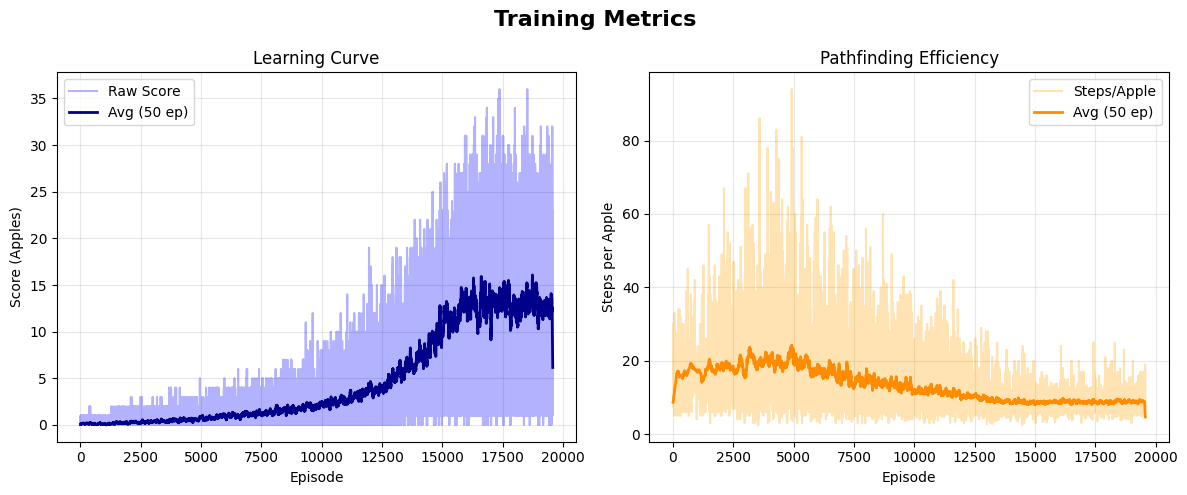

In [43]:
metrics.plot(show=True, save=False)
plt.show()

## 9. Training Loss Analysis


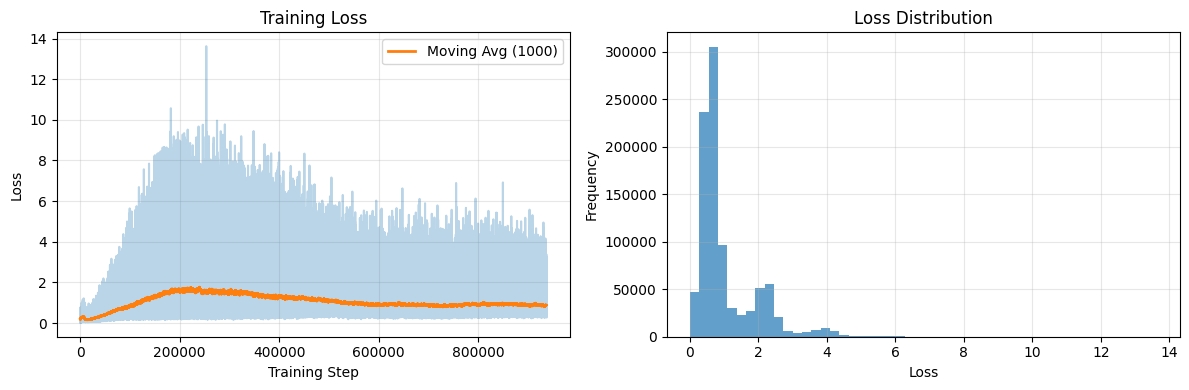

Loss Statistics:
  Mean: 1.0603
  Std: 0.9142
  Min: 0.0102
  Max: 13.6241


In [44]:
if agent.losses:
    plt.figure(figsize=(12, 4))

    # Raw loss
    plt.subplot(1, 2, 1)
    plt.plot(agent.losses, alpha=0.3)
    if len(agent.losses) > 1000:
        window = 1000
        smoothed = np.convolve(agent.losses, np.ones(window) / window, mode="valid")
        plt.plot(smoothed, linewidth=2, label=f"Moving Avg ({window})")
    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Loss distribution
    plt.subplot(1, 2, 2)
    plt.hist(agent.losses, bins=50, alpha=0.7)
    plt.xlabel("Loss")
    plt.ylabel("Frequency")
    plt.title("Loss Distribution")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"Loss Statistics:")
    print(f"  Mean: {np.mean(agent.losses):.4f}")
    print(f"  Std: {np.std(agent.losses):.4f}")
    print(f"  Min: {np.min(agent.losses):.4f}")
    print(f"  Max: {np.max(agent.losses):.4f}")

## 10. Test the Trained Agent


In [72]:
agent.epsilon = 0.0  # Pure exploitation

test_episodes = 10
test_scores = []

print(f"Testing for {test_episodes} episodes...")

for ep in range(test_episodes):
    state = game.reset()
    done = False

    while not done:
        action = agent.get_action(state)
        reward, done, score = game.step(action)
        state = game.get_state()

    test_scores.append(score)
    print(f"  Episode {ep+1}: Score = {score}")

print(f"\nTest Results:")
print(f"  Average: {np.mean(test_scores):.2f}")
print(f"  Best: {max(test_scores)}")
print(f"  Worst: {min(test_scores)}")

Testing for 10 episodes...
  Episode 1: Score = 29
  Episode 2: Score = 19
  Episode 3: Score = 33
  Episode 4: Score = 13
  Episode 5: Score = 26
  Episode 6: Score = 24
  Episode 7: Score = 17
  Episode 8: Score = 35
  Episode 9: Score = 23
  Episode 10: Score = 26

Test Results:
  Average: 24.50
  Best: 35
  Worst: 13


## 11. Export for Google Colab (Optional)

If running on Google Colab, you can download the trained model:


In [ ]:
# Uncomment to download model in Colab
# from google.colab import files
# files.download(MODEL_PATH)